# Atividade 2
Aplicar conceitos de Visão Computacional para reconstruir um modelo 3D (nuvem de pontos e/ou malha) de um objeto/cena a partir de múltiplas imagens, desenvolvendo com-
petências em extração de características, emparelhamento, geometria epipolar, estimação de pose, triangulação e (opcionalmente) densificação/malha/texturização.

# Progresso e próximos passos
- [ ] Etapa 1: Coleta das Imagens e Preparação
  - coloque o passo a passo
- [ ] Etapa 2: Detecção e Extração de Características
  - coloque o passo a passo
- [ ] Etapa 3: Emparelhamento e Geometria Epipolar
  - coloque o passoa a passo
- [ ] Etapa 4: Reconstrução 3D e (Opcional) Densificação/Malha
  - coloque o passoa a passo
- [ ] Etapa 5: Avaliação, Demonstração e Relatório
  - coloque o passo a passo
- [ ] Opcional 1: Recuperar escala absoluta
- [ ] Opcional 2: Marcar poses das câmeras no espaço 3D e exportar GLB/OBJ para visualização web.
- [ ] Opcional 3: Tratar casos difíceis: baixa textura, iluminação desafiadora, oclusões, superfícies brilhantes.
- [ ] Opcional 4: Comparar patch-match vs. métodos alternativos de densificação (se aplicável).


## Etapa 1: Preparação das imagens

In [60]:
%pip install numpy opencv-python matplotlib mpl_toolkits scipy

import os
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits
Note: you may need to restart the kernel to use updated packages.


In [61]:
# drive.mount('/content/drive', force_remount=True)
# input_dir = '/content/drive/MyDrive/mc949/scan6/'
input_dir = 'data/scan6'


In [62]:
# List all files in the input directory
image_files = os.listdir(input_dir)

# Filter files that end with 'max.png'
max_images = [f for f in image_files if re.search(r'max\.png$', f)]



In [63]:
images = [cv2.imread(os.path.join(input_dir, max_image)) for max_image in sorted(max_images)]

## Etapa 2: Detecção e Extração de Características

### Achando os keypoints via SIFT

Detectando os keypoints via SIFT e ORB, mostrando as features em fundo "homogêneo" e então mostrando as imagens sobrepostas aos seus keypoints

In [64]:
def sift_detector(img, n_features=None):
    # Checa se a imagem já está em escala de cinza
    if len(img.shape) == 2:
        gray_img = img
    else:
        # Converte para escala de cinza
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if n_features:
        # Inicializa o detector SIFT com o número de melhores features desejado
        sift = cv2.SIFT_create(nfeatures=n_features)
    else:
        sift = cv2.SIFT_create()

    # Detecta os keypoints
    keypoints = sift.detect(gray_img, None)

    return keypoints

sift_keypoints = [sift_detector(img=img) for img in images]
print(f"Número de keypoints encontrados pelo sift: {[len(kp) for kp in sift_keypoints]}")

sift_keypoints_filtered = [sift_detector(img=img, n_features=500) for img in images]
print(f"Número de keypoints encontrados pelo sift pós-filtragem: {[len(kp) for kp in sift_keypoints_filtered]}")

Número de keypoints encontrados pelo sift: [14631, 16473, 16939, 17261, 14783, 13564, 15724, 16800, 16654, 15507, 15025, 11986, 14166, 15272, 16232, 16710, 17247, 16513, 12629, 8773, 15087, 17320, 17071, 16627, 15945, 15321, 14630, 12588, 9770, 11633, 13282, 14044, 14425, 15468, 15448, 16137, 15620, 12974, 8429, 12514, 13982, 14104, 13464, 13562, 12569, 12044, 11466, 10076, 8682]
Número de keypoints encontrados pelo sift pós-filtragem: [500, 500, 501, 501, 501, 502, 500, 500, 500, 501, 500, 500, 500, 500, 500, 500, 500, 500, 500, 501, 501, 501, 500, 500, 500, 500, 500, 501, 500, 500, 500, 500, 500, 500, 501, 500, 500, 501, 500, 500, 500, 501, 500, 500, 500, 501, 500, 500, 500]


### Achando os keypoints via ORB

In [65]:
def orb_detector(img, nfeatures=30000):
    # Check if image is already grayscale
    if len(img.shape) == 2:
        gray_img = img
    else:
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=nfeatures)
    kp  = orb.detect(gray_img, None)

    return kp

orb_keypoints = [orb_detector(img) for img in images]
print(f"Número de keypoints encontrados pelo orb: {[len(kp) for kp in orb_keypoints]}")

orb_keypoints_filtered = [orb_detector(img, nfeatures=500) for img in images]
print(f"Número de keypoints encontrados pelo orb pós-filtragem: {[len(kp) for kp in orb_keypoints_filtered]}")

Número de keypoints encontrados pelo orb: [29094, 29641, 29831, 29813, 29306, 29173, 29700, 29731, 29792, 29558, 29382, 28636, 29112, 29238, 29362, 29635, 29711, 29509, 29112, 27055, 29040, 29589, 29665, 29294, 29299, 29231, 29071, 28596, 27090, 28079, 28536, 29064, 29101, 29098, 29263, 29265, 29013, 28450, 25674, 28291, 28755, 28816, 28543, 28369, 28307, 28279, 27719, 26693, 25553]
Número de keypoints encontrados pelo orb pós-filtragem: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]



 Keypoints SIFT para a imagem 1:


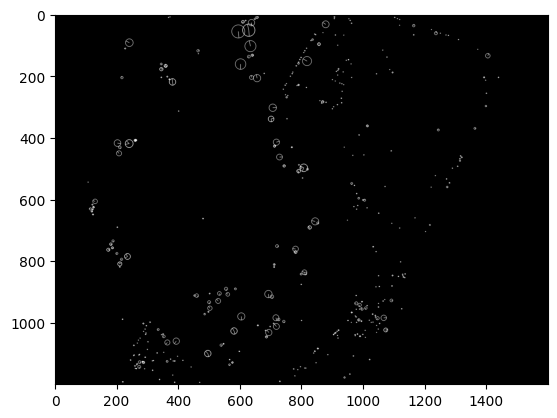


 Keypoints SIFT para a imagem 2:


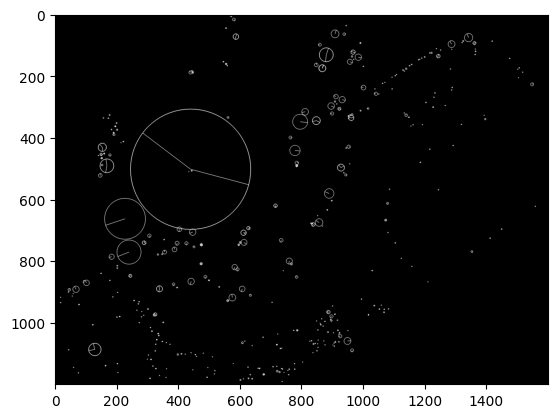

In [66]:
n = 2
for i in range(n):
    black_canvas_sift_filtered = np.zeros_like(images[i])
    image_with_sift_filtered_keypoints_on_black = cv2.drawKeypoints(black_canvas_sift_filtered, sift_keypoints_filtered[i], None, color=(255, 255, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    print(f"\n Keypoints SIFT para a imagem {i+1}:")
    #cv2_imshow(image_with_sift_filtered_keypoints_on_black)
    plt.imshow(image_with_sift_filtered_keypoints_on_black)
    plt.show()

Sobreposição dos keypoints SIFT para imagem 1


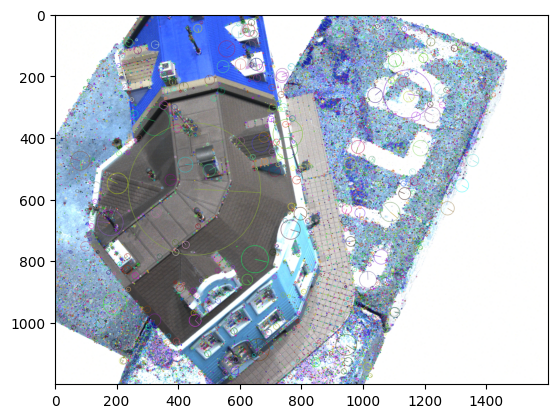

Sobreposição dos keypoints SIFT para imagem 2


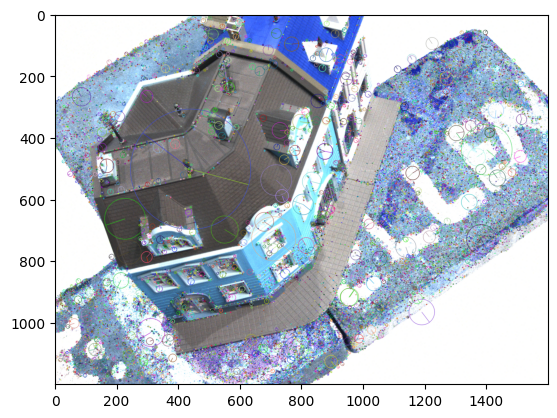

In [67]:
n = 2
for i in range(n):
  image_with_keypoints = cv2.drawKeypoints(images[i], sift_keypoints[i], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  print(f"Sobreposição dos keypoints SIFT para imagem {i+1}")
  #cv2_imshow(image_with_keypoints)
  plt.imshow(image_with_keypoints)
  plt.show()

## Etapa 3: Emparelhamento e Geometria Epipolar

In [68]:
def sift_descriptor(img, kp):
     sift = cv2.SIFT_create()
     sift_descriptors = sift.compute(img, kp)

     return sift_descriptors[1]

In [69]:
# Match features using FLANN matcher
def flann_matcher(img1, img2, n_features=None):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Filter the keypoints
    if n_features:
      kp1 = sift_detector(img1, n_features=n_features)
      kp2 = sift_detector(img2, n_features=n_features)
    else:
      kp1 = sift_detector(img1)
      kp2 = sift_detector(img2)

    des1 = sift_descriptor(img1, kp1)
    des2 = sift_descriptor(img2, kp2)
    mtch = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for match_pair in mtch:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

    if len(good_matches) < 4:
        return None, None, None

    good_matches_sorted = sorted(good_matches, key=lambda x: x.distance)

    # Extract matched points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches_sorted]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches_sorted]).reshape(-1, 1, 2)

    return src_pts, dst_pts, good_matches_sorted

matches = []
for i in range(len(images) - 1):
    src_pts, dst_pts, good_matches = flann_matcher(images[i], images[i+1], n_features=500)
    matches.append(good_matches[:100])

print(f"Number of good matches found between consecutive images: {[len(m) for m in matches]}")

Number of good matches found between consecutive images: [90, 80, 57, 46, 58, 33, 37, 85, 100, 100, 86, 100, 100, 100, 100, 88, 79, 40, 32, 32, 67, 100, 100, 100, 100, 100, 100, 74, 100, 100, 100, 100, 100, 100, 100, 100, 71, 33, 56, 100, 100, 100, 100, 100, 100, 100, 100, 83]


Visualizando Matchings


 80 Matches between image 2 and image 3:


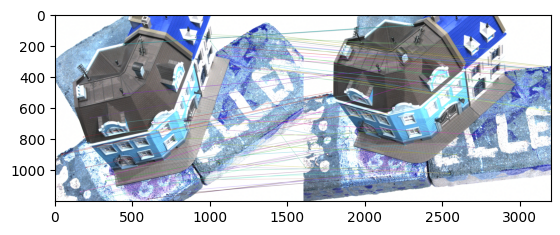

In [70]:
# Visualize the matches between consecutive images
i = 1
if len(matches[i]) > 0:
    img1 = images[i]
    img2 = images[i+1]
    # Draw matches
    img_matches = cv2.drawMatches(img1, sift_keypoints_filtered[i], img2, sift_keypoints_filtered[i+1], matches[i], None, flags=2)
    print(f"\n {len(matches[i])} Matches between image {i+1} and image {i+2}:")
    #cv2_imshow(img_matches)
    plt.imshow(img_matches)
    plt.show()
else:
    print(f"No good matches found between image {i+1} and image {i+2}.")

Estimar poses das câmeras (R,t) e triangular pontos 3D iniciais

In [71]:
from mpl_toolkits.mplot3d import Axes3D

def estimate_pose(kp1, kp2,  src_pts, dst_pts, matches, K, method=cv2.RANSAC, prob=0.999, threshold=1.0):
    """
    Estimate the relative pose between two cameras using matched features.
    """
    # Estimate essential matrix
    E, mask = cv2.findEssentialMat(src_pts, dst_pts, K, method, prob, threshold)
    
    # Recover pose from essential matrix
    _, R, t, mask = cv2.recoverPose(E, src_pts, dst_pts, K, mask=mask)
    
    inlier_matches = [matches[i] for i in range(len(matches)) if mask[i] > 0]
    print(f"Estimated pose with {np.sum(mask)} inliers out of {len(matches)} matches")
    
    return E, R, t, mask, inlier_matches

In [72]:
def triangulate_points(kp1, kp2, matches, K, R1, t1, R2, t2):
    """
    Triangulate 3D points from two views.
    """

    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # Create projection matrices
    P1 = np.dot(K, np.hstack((R1, t1)))
    P2 = np.dot(K, np.hstack((R2, t2)))
    
    # Triangulate points
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    
    # Convert to 3D points
    points_3d = points_4d[:3] / points_4d[3]
    
    return points_3d.T

In [73]:
def visualize_points_and_cameras(points_3d, R1, t1, R2, t2):
    """
    Visualize 3D points and camera positions.
    """

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='b', s=1)
    
    # Helper function to create camera visualization
    def plot_camera(R, t, color):
        # Camera center
        center = -R.T @ t
        ax.scatter(center[0], center[1], center[2], c=color, s=100, marker='o')
        
        # Camera axes (showing orientation)
        axes_length = 0.5  # Scale to make it visible
        for i, c in zip(range(3), ['r', 'g', 'b']):
            axis = R.T[:, i] * axes_length
            ax.quiver(center[0], center[1], center[2], 
                      axis[0], axis[1], axis[2], 
                      color=c, arrow_length_ratio=0.1)
    
    # Plot cameras
    plot_camera(R1, t1, 'red')
    plot_camera(R2, t2, 'green')
    
    ax.set_title('3D Reconstruction: Points and Cameras')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Try to make axes equal
    max_range = np.max([
        np.max(points_3d[:, 0]) - np.min(points_3d[:, 0]),
        np.max(points_3d[:, 1]) - np.min(points_3d[:, 1]),
        np.max(points_3d[:, 2]) - np.min(points_3d[:, 2])
    ])
    
    mid_x = (np.max(points_3d[:, 0]) + np.min(points_3d[:, 0])) * 0.5
    mid_y = (np.max(points_3d[:, 1]) + np.min(points_3d[:, 1])) * 0.5
    mid_z = (np.max(points_3d[:, 2]) + np.min(points_3d[:, 2])) * 0.5
    
    ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
    ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
    ax.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)
    
    plt.tight_layout()
    plt.show()

Pose estimation example

In [89]:
K = np.array([
    [949.97226758,   0.,         630.81760602],
    [  0.,         949.47553139, 356.35824094],
    [  0.,           0.,           1.        ]
])

all_R = []
all_t = []
all_kps = []
all_inliers = []
all_src = []
all_dst = []
all_matches = []
    
# For first camera, we use identity rotation and zero translation
R1 = np.eye(3)
t1 = np.zeros((3, 1))

all_R.append(R1)
all_t.append(t1)

for i in range(len(images)):
    kp = sift_detector(images[i], n_features=500)
    all_kps.append(kp)
    print(f"Image {i}: {len(kp)} keypoints")

for i in range(len(images) - 1):

    img1 = images[i]
    img2 = images[i+1]

    kp1 = all_kps[i]
    kp2 = all_kps[i + 1]

    src_pts, dst_pts, matches = flann_matcher(img1, img2)
    all_src.append(src_pts)
    all_dst.append(dst_pts)
    all_matches.append(matches)
    # Estimate pose of second camera relative to first
    EssentialM, R2, t2, mask, inliers = estimate_pose(kp1, kp2, src_pts, dst_pts, matches, K, threshold=0.5)
    all_R.append(R2)
    all_t.append(t2)
    all_inliers.append(inliers)

Image 0: 500 keypoints
Image 1: 500 keypoints
Image 2: 501 keypoints
Image 3: 501 keypoints
Image 4: 501 keypoints
Image 5: 502 keypoints
Image 6: 500 keypoints
Image 7: 500 keypoints
Image 8: 500 keypoints
Image 9: 501 keypoints
Image 10: 500 keypoints
Image 11: 500 keypoints
Image 12: 500 keypoints
Image 13: 500 keypoints
Image 14: 500 keypoints
Image 15: 500 keypoints
Image 16: 500 keypoints
Image 17: 500 keypoints
Image 18: 500 keypoints
Image 19: 501 keypoints
Image 20: 501 keypoints
Image 21: 501 keypoints
Image 22: 500 keypoints
Image 23: 500 keypoints
Image 24: 500 keypoints
Image 25: 500 keypoints
Image 26: 500 keypoints
Image 27: 501 keypoints
Image 28: 500 keypoints
Image 29: 500 keypoints
Image 30: 500 keypoints
Image 31: 500 keypoints
Image 32: 500 keypoints
Image 33: 500 keypoints
Image 34: 501 keypoints
Image 35: 500 keypoints
Image 36: 500 keypoints
Image 37: 501 keypoints
Image 38: 500 keypoints
Image 39: 500 keypoints
Image 40: 500 keypoints
Image 41: 501 keypoints
Im

In [92]:
i = 1
img_inliers = cv2.drawMatches(images[i], all_kps[i], images[i + 1], all_kps[i + 1], all_inliers[i], None,
                              matchColor=(0,255,0), singlePointColor=None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_inliers)

error: OpenCV(4.12.0) /io/opencv/modules/features2d/src/draw.cpp:241: error: (-215:Assertion failed) i1 >= 0 && i1 < static_cast<int>(keypoints1.size()) in function 'drawMatches'


Linhas epipolares

In [79]:
def draw_epilines(img1_color, img2_color, lines, pts1, pts2):
    r, c = img1.shape[:2]
    for r_line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0, y0 = map(int, [0, -r_line[2]/r_line[1]])
        x1, y1 = map(int, [c, -(r_line[2]+r_line[0]*c)/r_line[1]])
        img1_color = cv2.line(img1_color, (x0,y0), (x1,y1), color,1)
        img1_color = cv2.circle(img1_color, tuple(np.int32(pt1).ravel()), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(np.int32(pt2).ravel()), 5, color, -1)
    return img1_color, img2_color

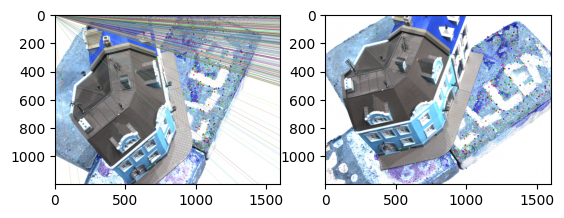

In [84]:
i = 1

src_pts = all_src[i - 1]
dst_pts = all_dst[i - 1]

mask_size = len(mask)
src_pts_truncated = src_pts[:mask_size]
dst_pts_truncated = dst_pts[:mask_size]

lines1 = cv2.computeCorrespondEpilines(src_pts_truncated.reshape(-1,1,2), 1, EssentialM)
lines1 = lines1.reshape(-1,3)

# pts2 → linhas em img1
lines2 = cv2.computeCorrespondEpilines(dst_pts_truncated.reshape(-1,1,2), 2, EssentialM)
lines2 = lines2.reshape(-1,3)

img1_epi, img2_epi = draw_epilines(images[i - 1].copy(), images[i].copy(), lines1,
                                   src_pts_truncated[mask.ravel()==1], dst_pts_truncated[mask.ravel()==1])
fig, ax = plt.subplots(1,2)
ax[0].imshow(img1_epi)
ax[1].imshow(img2_epi)
plt.show()

Visualizing the points and cameras

In [ ]:
# Fixed triangulate points with proper error handling and data consistency

# Triangulate points - CORRECTED VERSION  
points_3d_all = []
valid_pairs = 0

print("🔧 Starting triangulation for all image pairs...")

for i in range(len(images) - 1):
    print(f"\nProcessing pair {i}: images {i} and {i+1}")
    
    try:
        # Check if we have valid inliers for this pair
        if not all_inliers[i] or len(all_inliers[i]) < 5:
            print(f"  ❌ Skipping pair {i}: insufficient inliers ({len(all_inliers[i]) if all_inliers[i] else 0})")
            continue
            
        # Get the original matched keypoints that were used in pose estimation
        # We need to use the keypoints that were actually used in flann_matcher for this pair
        img1 = images[i]
        img2 = images[i+1]
        
        # Re-extract keypoints used in matching (this ensures consistency)
        src_pts, dst_pts, original_matches = flann_matcher(img1, img2)
        
        if src_pts is None:
            print(f"  ❌ Skipping pair {i}: no matches found")
            continue
            
        # Get keypoints used in matching
        kp1 = sift_detector(img1, n_features=500)  
        kp2 = sift_detector(img2, n_features=500)
        
        # Use the stored inliers for this pair
        inliers = all_inliers[i]
        
        # Get camera poses for this pair
        R1 = all_R[i] 
        t1 = all_t[i]
        R2 = all_R[i + 1] if i + 1 < len(all_R) else all_R[-1]
        t2 = all_t[i + 1] if i + 1 < len(all_t) else all_t[-1]
        
        print(f"  📊 Using {len(inliers)} inliers for triangulation")
        
        # Triangulate points for this pair
        points_3d = triangulate_points(kp1, kp2, inliers, K, R1, t1, R2, t2)
        
        # Filter out obviously bad points
        if len(points_3d) > 0:
            valid_mask = (
                (points_3d[:, 2] > 0.1) &   # In front of camera
                (points_3d[:, 2] < 100) &   # Not too far
                (np.abs(points_3d[:, 0]) < 50) & # Reasonable X range
                (np.abs(points_3d[:, 1]) < 50)   # Reasonable Y range
            )
            
            valid_points = points_3d[valid_mask]
            
            if len(valid_points) > 10:
                # Add spatial offset to separate point clouds from different pairs
                spatial_offset = np.array([i * 3.0, 0, 0])  
                valid_points += spatial_offset
                
                points_3d_all.append(valid_points)
                valid_pairs += 1
                print(f"  ✅ Generated {len(valid_points)} valid 3D points")
            else:
                print(f"  ⚠️  Only {len(valid_points)} points survived filtering")
        else:
            print(f"  ❌ No 3D points generated")
            
    except Exception as e:
        print(f"  ❌ Error triangulating pair {i}: {e}")
        continue

print(f"\n📊 Triangulation Summary:")
print(f"  Total pairs processed: {len(images) - 1}")
print(f"  Successful triangulations: {valid_pairs}")
print(f"  Point clouds generated: {len(points_3d_all)}")

# Combine and visualize results
if len(points_3d_all) > 0:
    all_combined_points = np.vstack(points_3d_all)
    print(f"  Total 3D points: {len(all_combined_points)}")
    
    # Enhanced visualization for multiple pairs
    def visualize_multiview_reconstruction(all_points, valid_pairs_count):
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot all points with different colors for each pair
        if valid_pairs_count > 1:
            colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
            start_idx = 0
            
            for i, points in enumerate(points_3d_all):
                color = colors[i % len(colors)]
                ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                          c=color, s=1, alpha=0.7, label=f'Pair {i}')
        else:
            ax.scatter(all_points[:, 0], all_points[:, 1], all_points[:, 2], 
                      c='blue', s=1, alpha=0.7, label='3D Points')
        
        # Plot camera positions (simplified)
        for i in range(min(valid_pairs_count + 1, len(all_R))):
            if i < len(all_R) and i < len(all_t):
                center = -all_R[i].T @ all_t[i]
                ax.scatter(center[0], center[1], center[2], 
                          c='red', s=100, marker='o', edgecolors='black')
        
        ax.set_title(f'Multi-View 3D Reconstruction\n{valid_pairs_count} successful pairs, {len(all_points)} total points')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Equal aspect ratio
        max_range = np.array([
            all_points[:, 0].max() - all_points[:, 0].min(),
            all_points[:, 1].max() - all_points[:, 1].min(), 
            all_points[:, 2].max() - all_points[:, 2].min()
        ]).max() / 2.0
        
        mid = [all_points[:, i].mean() for i in range(3)]
        for i, (set_lim, mid_val) in enumerate(zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], mid)):
            set_lim(mid_val - max_range, mid_val + max_range)
            
        if valid_pairs_count <= 10:
            ax.legend()
            
        plt.tight_layout()
        plt.show()
    
    # Visualize results
    visualize_multiview_reconstruction(all_combined_points, valid_pairs)
    
else:
    print("❌ No 3D points generated. Check:")
    print("  - Are there sufficient matches between images?")
    print("  - Are the camera poses estimated correctly?") 
    print("  - Try reducing filtering thresholds")

🔧 Starting triangulation for all image pairs...

Processing pair 0: images 0 and 1
  📊 Using 2011 inliers for triangulation
  ❌ Error triangulating pair 0: tuple index out of range

Processing pair 1: images 1 and 2
  📊 Using 1492 inliers for triangulation
  ❌ Error triangulating pair 1: tuple index out of range

Processing pair 2: images 2 and 3
  📊 Using 1554 inliers for triangulation
  ❌ Error triangulating pair 2: tuple index out of range

Processing pair 3: images 3 and 4
  📊 Using 904 inliers for triangulation
  ❌ Error triangulating pair 3: tuple index out of range

Processing pair 4: images 4 and 5
  📊 Using 771 inliers for triangulation
  ❌ Error triangulating pair 4: tuple index out of range

Processing pair 5: images 5 and 6
  📊 Using 586 inliers for triangulation
  ❌ Error triangulating pair 5: tuple index out of range

Processing pair 6: images 6 and 7
  📊 Using 934 inliers for triangulation
  ❌ Error triangulating pair 6: tuple index out of range

Processing pair 7: image